# Predictions

In [ ]:
!pip3 install sklearn

### Model for Gender prediction 

Importing the tensorflow framework and setting up the environment

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
from sklearn.model_selection import train_test_split
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data=pd.read_csv("dataset/dataset.csv")
data=data.drop("img_name",axis=1)
columns = ["age", "ethnicity", "gender"]
y = data.drop("pixels", axis=1)
x = data.drop(columns, axis=1)


In [15]:
num_pixels = len(x['pixels'][0].split(" "))
img_height = int(np.sqrt(len(x['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(x['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)
x = pd.Series(x["pixels"])
x = x.apply(lambda x: x.split(' '))
x = x.apply(lambda x: np.array(list(map(lambda z: np.int(z), x))))
x = np.array(x)
x = np.stack(np.array(x), axis=0)
x = np.reshape(x, (-1, 48, 48))

# reshape data
x = x.reshape(-1, 48, 48, 1)
print("x shape: ", x.shape)


2304 48 48


/tmp/ipykernel_4690/4050057615.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.apply(lambda x: np.array(list(map(lambda z: np.int(z), x))))


x shape:  (23705, 48, 48, 1)


Splitting the data for test and train. x has been previosly been defined as the pixels column from the dataset(its the feature class), and y is the gender class(targetclass). 
- X_train - is the pixel data for training
- y_train - is the gender data for training
- X_test - is the pixel data for testing
- y_test - is the gender data for testing

the portion of the dataset reserved for testing is 22%, with a random number generator seed 37

In [17]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.22, random_state=37
)

In [18]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

### The GenderModel

For our model we are using Keras CNN's.
 A Sequencial model is a linear stack of layers. In our case we have a depth of 10 layers(input and output included). as input we take a 48x48 image. the next layer 

Conv2D(2D convolution layer for blurring, sharpening, embossing, edge detection, and more by doing a convolution between a kernel and an image), with  a rectifier linear Unit Activation, and it 'zooms' in from the 48x48 image to ignore image margins.

Batch normalization is a method used to make artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. so th ebatch normalization layer re-scales the data after the convolution takes place. It's usually a good practice to normalize the data in the network.

MaxPooling2D - Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network.This makes the model more robust to variations.

![title](presentation/maxPool.png)

The flattening layer transformes the pooled data from the pooling layer and transforms it into a long vector of input data that can be passed to the next dense layer for more processing.


![title](presentation/flattening.png)

![title](presentation/flattening2.png)

Finally our model has a dropout layer that helps to correct a possible overfitting.We randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those 'dirty' patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust. In our case we are dropping 30% ot the connections.

Our last layer produces the output hence the seize of one unit. As activation we are using a sigmod function that tends to work very well for Binary Classification.

In [32]:
inputShape = (48,48,1)

genderModel = tf.keras.Sequential([
    layers.InputLayer(input_shape=inputShape),
    layers.Conv2D(32,(3,3),activation='relu',input_shape = (32,32,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid')
])

### Compiling the model
We chose to compile our model with the sgd optimizer. We did tests before with the adam optimizer, but we decided to stick with SGD because we got better results with it. Both SGD and ADAM are popular gradient descent algorithms, that can be found in use in most Tutorials and bibliography.

Since our Gender prediction is a Binary classification Problem, for  our loss funciton we decided to use BinaryCrossentropy. For metrics we are only using accuracy. 

https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/

![title](presentation/types_of_activation_&_loss.png)

In [33]:
genderModel.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


After training the model a couple of times, the training history graph tells me that i get at best 28% of prediction Success. Therefore a stoppin function is created after reaching that metric

In [34]:
class customStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.28):
            print("\nReached 0.2700 val_loss! cancelling training!")
            self.model.stop_training = True

### Overview of our model

In [35]:
genderModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                      

### Fit the data
fit the model with the training data, with a batch size of 64 Samples.The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. Validation Split is the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. we are using 10% of the dataset. As callbacks we are using earlyStopping and a custom function defined above.

In [36]:
history = genderModel.fit(
    X_train, y_train, epochs=15, batch_size=64,validation_split=0.1, callbacks=[early_stopping,customStopping()],
)

Epoch 1/15
260/260 [==============================] - 21s 79ms/step - loss: 0.5221 - accuracy: 0.7509 - val_loss: 0.4118 - val_accuracy: 0.8210
Epoch 2/15
260/260 [==============================] - 20s 77ms/step - loss: 0.3758 - accuracy: 0.8303 - val_loss: 0.3509 - val_accuracy: 0.8442
Epoch 3/15
260/260 [==============================] - 21s 79ms/step - loss: 0.3312 - accuracy: 0.8487 - val_loss: 0.3188 - val_accuracy: 0.8588
Epoch 4/15
260/260 [==============================] - 21s 82ms/step - loss: 0.3042 - accuracy: 0.8660 - val_loss: 0.3442 - val_accuracy: 0.8513
Epoch 5/15
260/260 [==============================] - 20s 77ms/step - loss: 0.2800 - accuracy: 0.8751 - val_loss: 0.3099 - val_accuracy: 0.8664
Epoch 6/15
260/260 [==============================] - 20s 77ms/step - loss: 0.2648 - accuracy: 0.8864 - val_loss: 0.3026 - val_accuracy: 0.8686
Epoch 7/15
260/260 [==============================] - 20s 77ms/step - loss: 0.2528 - accuracy: 0.8930 - val_loss: 0.2842 - val_accuracy:

### Evaluating our model's training

Gender Model Training history
Minimum validation loss: 0.269796758890152


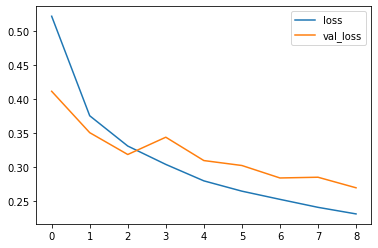

In [37]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Gender Model Training history")
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Gender Model Training history
MAximum validation Accuracy: 0.8858842849731445


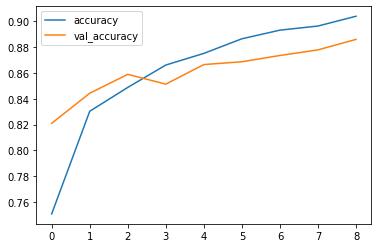

In [38]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Gender Model Training history")
print("MAximum validation Accuracy: {}".format(history_df['val_accuracy'].max()))

In [39]:
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.522149,0.750901,0.411752,0.820984
1,0.375751,0.830288,0.350899,0.844240
2,0.331216,0.848738,0.318770,0.858843
3,0.304187,0.866046,0.344196,0.851271
4,0.279989,0.875060,0.309853,0.866414


### Saving Model and weights to Disk

In [40]:
from keras.models import model_from_json
gender_model_json = genderModel.to_json()
with open("models/gender/gender_model.json", "w") as json_file:
    json_file.write(gender_model_json)
# serialize weights to HDF5
genderModel.save_weights("models/gender/gender_model.h5")
print("Saved model to disk")

Saved model to disk


### load model from disk


In [41]:
from keras.models import model_from_json

json_file = open('models/gender/gender_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("models/gender/gender_model.h5")
print("Loaded model from disk")


Loaded model from disk


## Age Model

#### In terms of spliting the data, we take the same approach as for the gender model.

In [42]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.22, random_state=37
)

#### We have basically the same layer structure for our model, but we changed the last layer activation function to relu, because now the problem has turned from a binary classification into a regression.

In [50]:
AgeModel = tf.keras.Sequential([
    layers.InputLayer(input_shape=(48,48,1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1,'relu')
])

#### in relation to the last model, we changed the optimizer function to adam, which is a general go-to optimizer function. we tried sgm, but the results with adam were better. As the loss mesurement  we are using meam_squared_error, again because our problem is now a regression problem, and as metrics, instead of accuracy, we are using the mean average error, because we want to test how far away we are froma  certain number as oposite as the last model, where we were measuring a  probability of error.

In [51]:
AgeModel.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


In [52]:
AgeModel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                      

In [53]:
class customStopping2(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<97):
            print("\nReached 97 val_loss so cancelling training!")
            self.model.stop_training = True

In [54]:
history1 = AgeModel.fit(
    X_train, y_train, epochs=15, validation_split=0.1, batch_size=64, callbacks=[early_stopping,customStopping2()],
)

Epoch 1/15
260/260 [==============================] - 24s 90ms/step - loss: 319.2230 - mae: 13.4307 - val_loss: 367.3109 - val_mae: 16.4108
Epoch 2/15
260/260 [==============================] - 25s 95ms/step - loss: 181.8119 - mae: 10.0659 - val_loss: 292.6145 - val_mae: 13.2427
Epoch 3/15
260/260 [==============================] - 23s 88ms/step - loss: 161.6317 - mae: 9.4420 - val_loss: 143.0332 - val_mae: 8.5625
Epoch 4/15
260/260 [==============================] - 26s 100ms/step - loss: 151.1998 - mae: 9.0865 - val_loss: 104.9603 - val_mae: 7.6143
Epoch 5/15
260/260 [==============================] - 26s 99ms/step - loss: 137.6544 - mae: 8.6785 - val_loss: 105.2703 - val_mae: 7.4912
Epoch 6/15
260/260 [==============================] - 25s 95ms/step - loss: 128.8960 - mae: 8.3927 - val_loss: 108.7339 - val_mae: 7.7912
Epoch 7/15
260/260 [==============================] - 24s 91ms/step - loss: 122.8860 - mae: 8.1779 - val_loss: 120.1929 - val_mae: 7.7932
Epoch 8/15
260/260 [=========

Age Model Training history- With stopping function + no LL activation
Minimum validation loss: 98.65799713134766


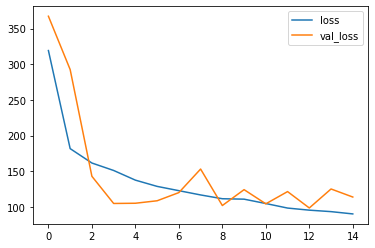

In [55]:
history_df_age = pd.DataFrame(history1.history)
history_df_age.loc[:, ['loss', 'val_loss']].plot();
print("Age Model Training history- With stopping function + no LL activation")
print("Minimum validation loss: {}".format(history_df_age['val_loss'].min()))

Age Model Training history- With stopping function + no LL activation
Minimum mean average error: 7.230589866638184


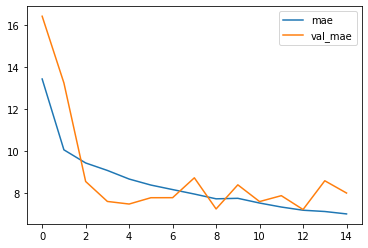

In [57]:
history_df_age = pd.DataFrame(history1.history)
history_df_age.loc[:, ['mae', 'val_mae']].plot();
print("Age Model Training history- With stopping function + no LL activation")
print("Minimum mean average error: {}".format(history_df_age['val_mae'].min()))

In [58]:
from keras.models import model_from_json
age_model_json = AgeModel.to_json()
with open("models/age/age_model.json", "w") as json_file:
    json_file.write(age_model_json)
# serialize weights to HDF5
AgeModel.save_weights("models/age/age_model.h5")
print("Saved model to disk")

Saved model to disk


## Ethnicity Model

In [59]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.22, random_state=37
)

The model has the usual layer types, differing only on the last layer activation type.
Pushing the "softmax" activation into the cross-entropy loss layer significantly simplifies the loss computation and makes it more numerically stable.

In [60]:
eth_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(48,48,1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.Dense(5,activation='softmax')
])

#### We are still using adam as our otimizer,


#### The usage of SparceCategoriacCrossEntropy is because our data are integers, and not one-hot encoded[0,1]


#### Again the use of accuracy as our metric is because there are 5 ethnic groups, and we want to measute the probablity of failing to chose the correct one.

In [61]:
eth_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
class customStopping3(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.79):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True

In [63]:
eth_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 6400)              0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [64]:
history2 = eth_model.fit(
    X_train, y_train, epochs=15, validation_split=0.1, batch_size=64,
)

Epoch 1/15


/home/bento/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


260/260 [==============================] - 16s 60ms/step - loss: 2.4460 - accuracy: 0.4239 - val_loss: 1.2431 - val_accuracy: 0.5300
Epoch 2/15
260/260 [==============================] - 16s 60ms/step - loss: 1.2264 - accuracy: 0.5177 - val_loss: 0.9853 - val_accuracy: 0.6268
Epoch 3/15
260/260 [==============================] - 15s 59ms/step - loss: 1.1333 - accuracy: 0.5493 - val_loss: 0.9221 - val_accuracy: 0.6263
Epoch 4/15
260/260 [==============================] - 15s 57ms/step - loss: 1.0873 - accuracy: 0.5636 - val_loss: 0.9358 - val_accuracy: 0.5949
Epoch 5/15
260/260 [==============================] - 15s 57ms/step - loss: 1.0567 - accuracy: 0.5788 - val_loss: 0.8386 - val_accuracy: 0.7015
Epoch 6/15
260/260 [==============================] - 15s 59ms/step - loss: 1.0353 - accuracy: 0.5799 - val_loss: 0.8776 - val_accuracy: 0.6825
Epoch 7/15
260/260 [==============================] - 15s 57ms/step - loss: 1.0128 - accuracy: 0.5850 - val_loss: 0.8314 - val_accuracy: 0.6912
Epo

Ethnic Model Training history- No stopping function + ADAM 
Minimum validation loss: 0.7677708268165588


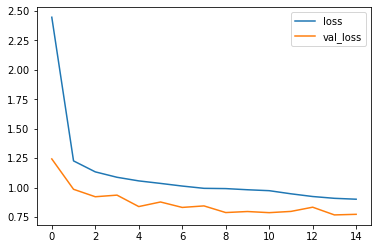

In [65]:
history_df_eth = pd.DataFrame(history2.history)
history_df_eth.loc[:, ['loss', 'val_loss']].plot();
print("Ethnic Model Training history- No stopping function + ADAM ")
print("Minimum validation loss: {}".format(history_df_eth['val_loss'].min()))

Ethnic Model Training history- No stopping function + ADAM 
Maximum validation Accuracy: 0.7468901872634888


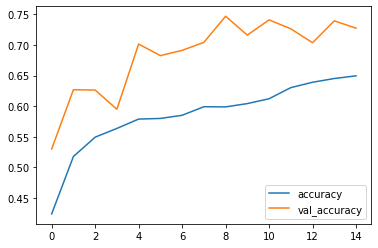

In [66]:
history_df_eth = pd.DataFrame(history2.history)
history_df_eth.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Ethnic Model Training history- No stopping function + ADAM ")
print("Maximum validation Accuracy: {}".format(history_df_eth['val_accuracy'].max()))

In [67]:
from keras.models import model_from_json
ethnic_model_json = eth_model.to_json()
with open("models/ethnia/eth_model.json", "w") as json_file:
    json_file.write(ethnic_model_json)
# serialize weights to HDF5
eth_model.save_weights("models/ethnia/eth_model.h5")
print("Saved model to disk")

Saved model to disk


### Testing the models

#### Since our pixel data is a string, we turn it into something more usefull

In [79]:
data['pixels'] = data['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

#### Function that use our models to predict a image we feed it

In [161]:
def face_prediction(image):
    
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    
    age_predict = int(AgeModel.predict(x))
    gender_predict = int(genderModel.predict(x))
    ethnicity_predict = np.argmax(eth_model.predict(x))
    
    gender = {0: 'Male', 1: 'Female'}
    eth_group = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'} 
    
    plt.imshow(image)
    plt.title('Age:{0}, Ethnicity:{1},Gender:{2}'.format(age_predict,eth_group[ethnicity_predict],gender[gender_predict]));
    plt.axis('off')

#### Show a random Face from the dataset

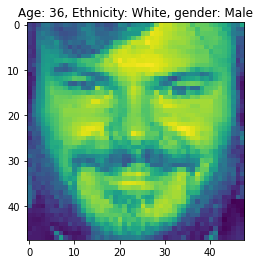

In [176]:
random_face = np.random.choice(len(data))

age = data['age'][random_face]
ethnicity = data['ethnicity'][random_face]
gender = data['gender'][random_face]
gender_plt = {0: 'Male', 1: 'Female'}
eth_group_plt = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'} 

plt.title('Age: {0}, Ethnicity: {1}, gender: {2}'.format(age, eth_group_plt[ethnicity], gender_plt[gender]));
plt.imshow(data['pixels'][random_face])



#### Predict the labels from the random face

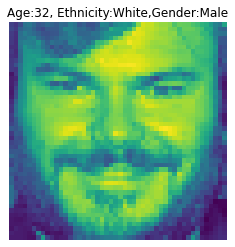

In [177]:
face_prediction(data['pixels'][random_face])